# Generative Adverserial Network
## An Introduction on 1-D Plane

In [ ]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from matplotlib import pyplot

## Type of Architecture Used

GAN use 2 models binded Sequentially together
1. Generator Model(Generates fake examples to fool)
2. Discriminator Model(Identifies if the given input is real or fake)

## **Discriminator Model**
Differentiates whether the given input is real or fake.(Normal Binary Classification problem)
1. A Dense Layer with 25 Nuerons. (LeakyReLU used as it is tested to get more stable answers)
2. Sigmoid Function for Classification.

In [ ]:
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, kernel_initializer='he_uniform', input_dim=n_inputs))
  model.add(LeakyReLU(alpha=0.05))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

## **Generator Model**
Generate fake examples good enough to fool discriminator. It takes input from something called latent dimension. Latent dimension has latent(hidden) points. We cannot compile this model yet.
1. A Dense Layer with 15 Nuerons. (LeakyReLU used as it is tested to get more stable answers)
2. Dense layer with Linear Function to generate examples.

In [ ]:
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.05))
	model.add(Dense(n_outputs, activation='linear'))
	return model

## **Generative Adversarial Model**
Stacks the Generator and discriminator sequentially. We dont have to train the Discriminator model here. We cannot train the generator individually as it depends on discriminator output. Generator is trained with the whole GAN model.
1. Generator Model.
2. Discriminator Model.

In [ ]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

Function to generate real samples

In [ ]:
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

Function to generate latent points. In this case, these points are random points.

In [ ]:
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

Fake examples are taken from latent space and fed to discriminator.

In [ ]:
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

Function to tell the performance.

In [ ]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

Train the whole GAN Model while separately training discriminator model.

In [ ]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.6499999761581421 0.7900000214576721


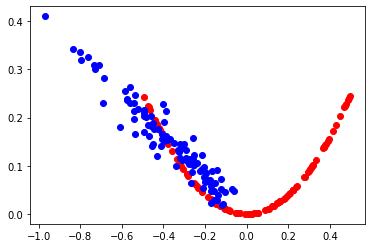

3999 0.4099999964237213 0.6100000143051147


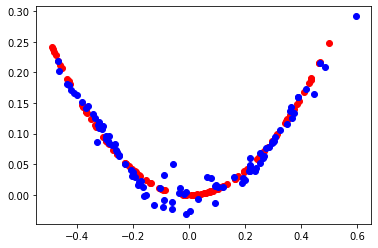

5999 0.11999999731779099 0.7699999809265137


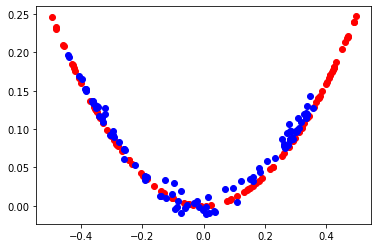

7999 0.6800000071525574 0.3799999952316284


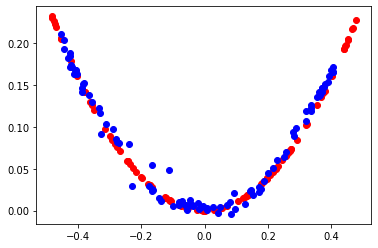

9999 0.5899999737739563 0.46000000834465027


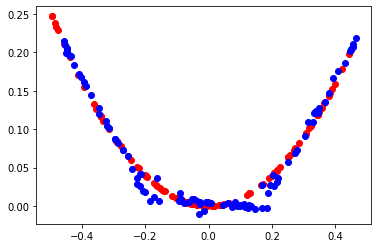

In [ ]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)